# Trénovanie modelu iba na základe DST indexu 2h dopredu 6 dozadu
Súbor: 6_dozadu_2_dopredu.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uni

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'DST+2']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+2'

y_col='DST+2'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()
y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [3]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-02-27 22:31:06.385493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6674 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
# callbacks
saved_model = "6_dozadu_2_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-02-27 22:31:17.821531: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


1139/1139 [==============================] - ETA: 0s - loss: 82.5302 - mae: 3.0571
Epoch 1: val_mae improved from inf to 2.17251, saving model to 6_dozadu_2_dopredu.hdf5
1139/1139 [==============================] - 75s 60ms/step - loss: 82.5302 - mae: 3.0571 - val_loss: 36.0846 - val_mae: 2.1725
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 15.9458 - mae: 1.4464
Epoch 2: val_mae did not improve from 2.17251
1139/1139 [==============================] - 67s 59ms/step - loss: 15.9458 - mae: 1.4464 - val_loss: 29.0431 - val_mae: 2.6706
Epoch 3/20
1139/1139 [==============================] - ETA: 0s - loss: 10.1699 - mae: 1.1158
Epoch 3: val_mae improved from 2.17251 to 2.01626, saving model to 6_dozadu_2_dopredu.hdf5
1139/1139 [==============================] - 67s 58ms/step - loss: 10.1699 - mae: 1.1158 - val_loss: 30.3637 - val_mae: 2.0163
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - loss: 9.6853 - mae: 1.1633
Epoch 4: val_mae improved from 

In [8]:
# load best model
model = keras.models.load_model('6_dozadu_2_dopredu.hdf5')

In [9]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 9s 14ms/step


In [10]:
y_pred

array([[ 12.981309],
       [ 12.970055],
       [ 10.215227],
       ...,
       [-26.421467],
       [-28.038404],
       [-22.781569]], dtype=float32)

In [11]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124633      2]
 [  5332  25286]]


In [12]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    124635
           1       1.00      0.83      0.90     30618

    accuracy                           0.97    155253
   macro avg       0.98      0.91      0.94    155253
weighted avg       0.97      0.97      0.96    155253



In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [14]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,14.0,12.981309
7,2004-07-22 05:00:00,14.0,12.970055
8,2004-07-22 06:00:00,11.0,10.215227
9,2004-07-22 07:00:00,11.0,10.238415
10,2004-07-22 08:00:00,9.0,8.456435
...,...,...,...
155254,2022-04-28 20:00:00,-23.0,-20.878910
155255,2022-04-28 21:00:00,-26.0,-23.680912
155256,2022-04-28 22:00:00,-29.0,-26.421467
155257,2022-04-28 23:00:00,-31.0,-28.038404


In [15]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.817176,-8.936204
std,16.340477,14.919836
min,-374.000000,-384.062012
25%,-16.000000,-14.987303
50%,-7.000000,-6.601009
75%,0.000000,0.143972
max,77.000000,67.466103


<AxesSubplot: >

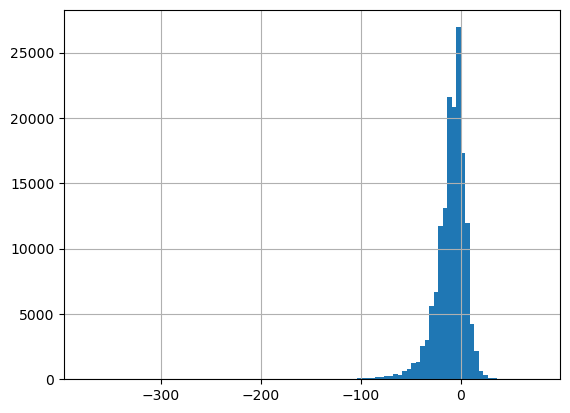

In [16]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

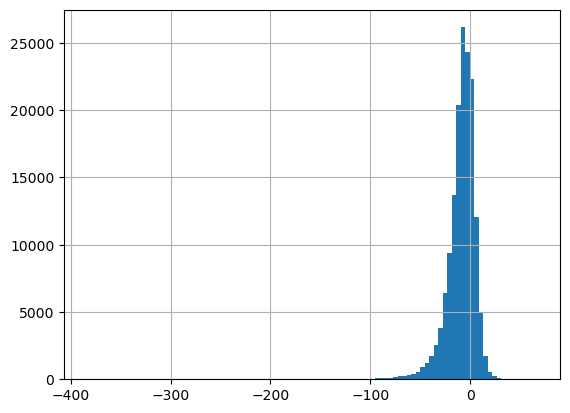

In [17]:
df["y_predict"].hist(bins=100)

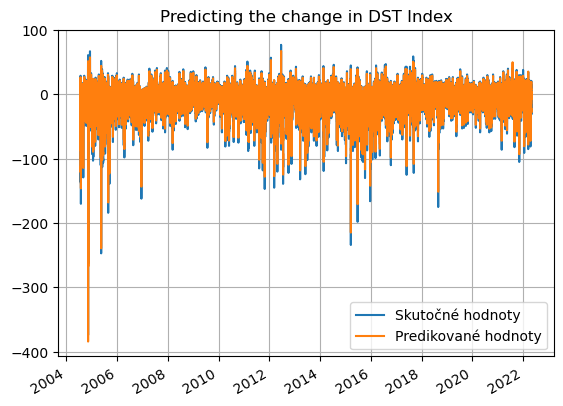

In [18]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [19]:
df.to_csv('predikcie_6h_dozadu_2h_dopredu.csv')

In [20]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

124633
2
5332
25286
TPR=0.825854072767653
TNR=0.9999839531431781
PPV=0.999920911104081
NPV=0.9589735698072558
FPR=1.6046856821920006e-05
FNR=0.17414592723234698
FDR=7.908889591901297e-05
ACC=0.9656431759772758
MCC=0.889882871603117
